In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip install Sastrawi
!pip install googletrans==3.1.0a0
!pip install imbalanced-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from googletrans import Translator
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Load Data
df = pd.read_csv('/content/drive/MyDrive/PBA/harveymoeis.csv')
# Mengetahui jumlah data (jumlah baris dan kolom)
jumlah_baris = df.shape[0]  # Jumlah baris
jumlah_kolom = df.shape[1]  # Jumlah kolom

# Menampilkan hasil
print(f"Jumlah baris (data): {jumlah_baris}")
print(f"Jumlah kolom (fitur): {jumlah_kolom}")

Jumlah baris (data): 110
Jumlah kolom (fitur): 15


In [ ]:
# 2. Preprocessing Text
def preprocess_text(text):
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text), flags=re.MULTILINE)

    # Menghapus mentions dan hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Menghapus karakter khusus
    text = re.sub(r'[^\w\s]', '', text)

    # Mengubah ke lowercase
    text = text.lower()

    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    return text

In [ ]:
def advanced_preprocess(text):
    # Stopword removal
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    text = stopword.remove(text)

    # Stemming
    # Melakukan stemming (mengubah kata ke bentuk dasar)
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)

    return text

In [ ]:
# 3. Labeling Data (menggunakan kamus sederhana untuk demo)
def simple_sentiment_analyzer(text):
    positive_words = ['bagus', 'baik', 'hebat', 'setuju', 'dukung', 'benar', 'adil']
    negative_words = ['korupsi', 'buruk', 'jahat', 'curang', 'salah', 'busuk', 'korup']

    text = str(text).lower()
    score = 0

    for word in text.split():
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1

    if score > 0:
        return 1  # positive
    elif score < 0:
        return -1  # negative
    else:
        return 0  # neutral

In [ ]:
# Aplikasikan preprocessing
df['cleaned_text'] = df['full_text'].apply(preprocess_text)
df['processed_text'] = df['cleaned_text'].apply(advanced_preprocess)
df['sentiment'] = df['processed_text'].apply(simple_sentiment_analyzer)

In [ ]:
# 4. Feature Extraction menggunakan tf-idf
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])
y = df['sentiment']

In [ ]:
# 5. Handle Imbalanced Data dengan SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Sebelum SMOTE: menampilkan distribusi kelas pada data asli
print("Distribusi kelas sebelum SMOTE:")
print(y.value_counts())

# Setelah SMOTE: menampilkan distribusi kelas pada data setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_balanced).value_counts())


Distribusi kelas sebelum SMOTE:
sentiment
 0    74
-1    27
 1     9
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
sentiment
 0    74
-1    74
 1    74
Name: count, dtype: int64


In [ ]:
# 6. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# Menampilkan jumlah data latih dan data uji
print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")


Jumlah data latih: 177
Jumlah data uji: 45


In [ ]:
# 7. Train Model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# 8. Cross Validation
cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=5)

In [ ]:
# 9. Predictions.0
y_pred = model.predict(X_test)


In [ ]:
# 10. Evaluation model
def evaluate_model(y_test, y_pred):
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
# Evaluasi model
evaluate_model(y_test, y_pred)


Classification Report:
              precision    recall  f1-score   support

          -1       0.88      1.00      0.93        21
           0       1.00      0.64      0.78        11
           1       0.93      1.00      0.96        13

    accuracy                           0.91        45
   macro avg       0.93      0.88      0.89        45
weighted avg       0.92      0.91      0.90        45


Accuracy: 0.91


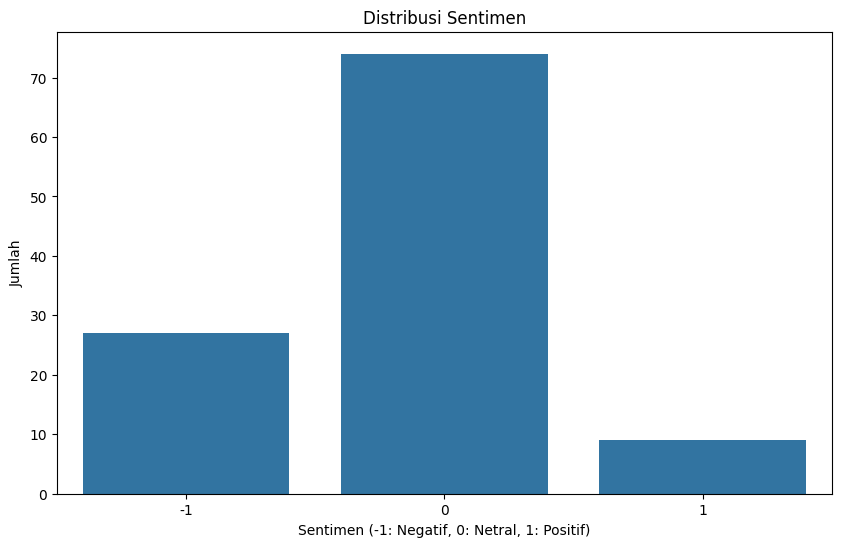

In [ ]:
# 11. Visualisasi Distribusi Sentimen
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen (-1: Negatif, 0: Netral, 1: Positif)')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
# 12. Save Model dan Vectorizer (opsional)
import pickle

In [ ]:
# Save model
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
# 13. Fungsi untuk prediksi teks baru
def predict_sentiment(text):
    # Preprocess
    cleaned = preprocess_text(text)
    processed = advanced_preprocess(cleaned)

    # Vectorize
    vector = vectorizer.transform([processed])

    # Predict
    prediction = model.predict(vector)[0]

    # Map prediction to sentiment
    sentiment_map = {
        -1: "Negatif",
        0: "Netral",
        1: "Positif"
    }

    return sentiment_map[prediction]

In [ ]:

sample_text = "Kasus korupsi ini sangat merugikan rakyat"
print(f"\nSentimen untuk teks '{sample_text}': {predict_sentiment(sample_text)}")


Sentimen untuk teks 'Kasus korupsi ini sangat merugikan rakyat': Negatif


In [ ]:
# 14. Analisis Kata-kata Penting
def analyze_important_words(vectorizer, model, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()

    # Get coefficients for each class
    coef_per_class = model.feature_log_prob_

    # For each class
    for i, sentiment in enumerate(['Negatif', 'Netral', 'Positif']):
        # Get top words
        top_coef_idx = coef_per_class[i].argsort()[-n_top_words:][::-1]
        top_words = [feature_names[idx] for idx in top_coef_idx]

        print(f"\nTop {n_top_words} kata penting untuk sentimen {sentiment}:")
        for word in top_words:
            print(f"- {word}")

# Analisis kata-kata penting
analyze_important_words(vectorizer, model)


Top 10 kata penting untuk sentimen Negatif:
- korupsi
- timah
- penjara
- rp
- tahun
- harvey
- moeis
- vonis
- kasus
- triliun

Top 10 kata penting untuk sentimen Netral:
- harvey
- moeis
- vonis
- tahun
- koruptor
- banding
- penjara
- sandra
- hukum
- aju

Top 10 kata penting untuk sentimen Positif:
- adil
- keluarga
- sopan
- tak
- punya
- lelucon
- diskon
- vonis
- ringan
- turun


In [ ]:
# Print ringkasan hasil
print("\nRINGKASAN HASIL ANALISIS:")
print(f"Total data: {len(df)}")
print(f"Rata-rata akurasi cross-validation: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"Distribusi sentimen awal:")
print(df['sentiment'].value_counts())


RINGKASAN HASIL ANALISIS:
Total data: 110
Rata-rata akurasi cross-validation: 0.81 ± 0.06
Distribusi sentimen awal:
sentiment
 0    74
-1    27
 1     9
Name: count, dtype: int64


In [ ]:
print(set(y_test))
print(set(y_pred))


{0, 1, -1}
{0, 1, -1}
